In [1]:
"""
use to install TA-lib library in Google Colab
"""

# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar xvzf ta-lib-0.4.0-src.tar.gz

# import os
# os.chdir('/content/ta-lib') # Can't use !cd in co-lab
# !./configure --prefix=/usr
# !make
# !make install
# !pip install TA-Lib

--2024-06-26 15:31:35--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-06-26 15:31:36--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-06-26 15:31:36--  http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Resolving nchc.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import talib as ta
import math

import warnings
warnings.filterwarnings('ignore')

Preprocessing data

In [2]:
class TechnicalIndicators:
    def __init__(self, data):
        self.data = data

    def add_momentum_indicators(self):
        self.data['RSI'] = ta.RSI(self.data['Close'], timeperiod=14)

    def add_volume_indicators(self):
        self.data['OBV'] = ta.OBV(self.data['Close'], self.data['Volume'])

    def add_volatility_indicators(self):
        self.data['Upper_BB'], self.data['Middle_BB'], self.data['Lower_BB'] = ta.BBANDS(self.data['Close'], timeperiod=20)

    def add_trend_indicators(self):
        self.data['ADX'] = ta.ADX(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=14)

    def add_other_indicators(self):
        self.data['DLR'] = np.log(self.data['Close'] / self.data['Close'].shift(1))

    def add_all_indicators(self):
        self.add_momentum_indicators()
        self.add_volume_indicators()
        self.add_volatility_indicators()
        self.add_trend_indicators()
        self.add_other_indicators()
        return self.data

Data Loading/Preprocessing

In [6]:
data = pd.read_csv('/content/xnas-itch-20230703.tbbo.csv')

# Preprocessing to create necessary columns
data['price']=data['price']/1e9
data['bid_px_00']=data['bid_px_00']/1e9
data['ask_px_00']=data['ask_px_00']/1e9

data['Close'] = data['price']
data['Volume'] = data['size']
data['High'] = data[['bid_px_00', 'ask_px_00']].max(axis=1)
data['Low'] = data[['bid_px_00', 'ask_px_00']].min(axis=1)
data['Open'] = data['Close'].shift(1).fillna(data['Close'])

data['ts_recv']= pd.to_datetime(data['ts_recv'], unit='ns')

ti = TechnicalIndicators(data)
df_with_indicators = ti.add_all_indicators()
df_with_indicators= df_with_indicators[35:]

In [7]:
df= df_with_indicators[["ts_recv", "price", "Close", "Volume", "High", "Low", 'RSI', 'OBV', 'Upper_BB', 'ADX', 'DLR']]
df.rename(columns={'ts_recv': 'timestamp'}, inplace=True)
df.set_index("timestamp", inplace=True)

In [8]:
resampled_df = df.resample('S').mean()
resampled_df.fillna(method='ffill', inplace=True)
resampled_df['target'] = resampled_df['Close'].shift(-60)
resampled_df['direction'] = resampled_df.apply(lambda row: 1 if (row['target'] - row['Close']) > 0 else -1, axis=1)
resampled_df.dropna(inplace=True)


In [9]:
TARGET_MEAN= resampled_df['target'].mean()
TARGET_STD= resampled_df['target'].std()

In [163]:
"""
Normalizing data (doesn't give good results)
"""
# for column in resampled_df.columns:
#     if column != 'direction':
#         resampled_df[column] = (resampled_df[column] - resampled_df[column].mean()) / resampled_df[column].std()

In [10]:
resampled_df.head()

,price,Close,Volume,High,Low,RSI,OBV,Upper_BB,ADX,DLR,target,direction
timestamp,,,,,,,,,,,,
2023-07-03 08:00:14,194.05,194.05,50.0,194.30,194.0,54.544543,-266.0,194.067305,97.309559,0.000000,194.268333,1
2023-07-03 08:00:15,194.21,194.21,10.0,194.21,194.0,85.890753,-256.0,194.125889,97.458593,0.000824,194.280000,1
2023-07-03 08:00:16,194.21,194.21,10.0,194.21,194.0,85.890753,-256.0,194.125889,97.458593,0.000824,194.280000,1
2023-07-03 08:00:17,194.21,194.21,10.0,194.21,194.0,85.890753,-256.0,194.125889,97.458593,0.000824,194.280000,1
2023-07-03 08:00:18,194.21,194.21,10.0,194.21,194.0,85.890753,-256.0,194.125889,97.458593,0.000824,194.280000,1


Creating custom dataset loader for model

In [11]:
"""
Data parameters
"""
input_seq_length = 120
target_seq_length = 60
batch_size = 32

In [12]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, seq_length=120, pred_length=60):
        self.dataframe = dataframe
        self.seq_length = seq_length
        self.pred_length = pred_length

        # Extract input features and target
        self.features = dataframe[["price", "Close", "Volume", "High", "Low", 'RSI', 'OBV', 'Upper_BB', 'ADX', 'DLR', 'direction']].values
        self.targets = dataframe[["target"]].values

        # Length of dataset
        self.data_len = len(self.dataframe) - self.seq_length - self.pred_length

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        # Get a sequence of data points (inputs) and its target (label)
        X = self.features[index:index+self.seq_length]
        y = self.targets[index+self.seq_length+self.pred_length]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [13]:
#test train split
train_size = int(0.85 * len(resampled_df))
train_df = resampled_df[:train_size]
test_df = resampled_df[train_size:]

In [14]:
train_dataset = CustomDataset(train_df, input_seq_length, target_seq_length)
test_dataset = CustomDataset(test_df, input_seq_length, target_seq_length)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Model

In [16]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, input_dim, head_size, num_heads, ff_dim, dropout=0.0):
        super(TransformerEncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(input_dim*num_heads, eps=1e-6)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=input_dim*num_heads, num_heads=num_heads, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_dim*num_heads, ff_dim)
        self.fc2 = nn.Linear(ff_dim, input_dim*num_heads)
        self.relu= nn.ReLU()

    def forward(self, x):
        # Attention and Normalization
        x_norm1 = self.layernorm(x)
        attn_output, _ = self.multihead_attn(x_norm1, x_norm1, x_norm1)
        x = x + self.dropout(attn_output)

        # Feed Forward Part
        x_norm2 = self.layernorm(x)
        y = self.fc1(x_norm2)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.fc2(y)
        y = self.dropout(y)
        x = x + y

        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, head_size, num_heads, ff_dim, num_layers, dropout=0.0):
        super(TransformerModel, self).__init__()
        self.initial_projection = nn.Linear(input_dim, input_dim * num_heads)
        self.encoder_layers = nn.ModuleList(
            [TransformerEncoderLayer(input_dim, head_size, num_heads, ff_dim, dropout) for _ in range(num_layers)]
        )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.layernorm = nn.LayerNorm(input_dim*num_heads, eps=1e-6)
        self.fc = nn.Linear(input_dim*num_heads, 1)
        self.relu= nn.ReLU()

    def forward(self, x):
        x= self.initial_projection(x)
        x = x.permute(1, 0, 2)  # Change to (sequence_length, batch_size, input_dim)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.permute(1, 2, 0)  # Change to (batch_size, input_dim, sequence_length)
        x = self.global_avg_pool(x).squeeze(-1)
        x = self.layernorm(x)
        x = self.fc(x)
        # x= self.relu(x)
        return x

# Model parameters
input_dim = train_df.shape[-1] -1
head_size = 256
num_heads = 16
ff_dim = 1024
num_layers = 12
dropout = 0.20

# Build the model
model = TransformerModel(input_dim, head_size, num_heads, ff_dim, num_layers, dropout)

In [17]:
from torchsummary import summary
summary(model.to("cuda"), input_size=(120, 11))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 120, 176]           2,112
         LayerNorm-2               [-1, 2, 176]             352
MultiheadAttention-3  [[-1, 2, 176], [-1, 120, 120]]               0
           Dropout-4               [-1, 2, 176]               0
         LayerNorm-5               [-1, 2, 176]             352
            Linear-6              [-1, 2, 1024]         181,248
              ReLU-7              [-1, 2, 1024]               0
           Dropout-8              [-1, 2, 1024]               0
            Linear-9               [-1, 2, 176]         180,400
          Dropout-10               [-1, 2, 176]               0
TransformerEncoderLayer-11               [-1, 2, 176]               0
        LayerNorm-12               [-1, 2, 176]             352
MultiheadAttention-13  [[-1, 2, 176], [-1, 120, 120]]               0
          Dropout-14  

In [70]:
model = TransformerModel(input_dim, head_size, num_heads, ff_dim, num_layers, dropout)
criterion = nn.L1Loss()  #Loss function MAE
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.001, total_iters=100)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

num_epochs = 30

save_dir= "/content/drive/MyDrive/trade_model/model.pth" #change path to save model weights


In [71]:
"""
Load pre-trained model weights
"""
# checkpoint = torch.load(save_dir)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


'\nLoad pre-trained model weights\n'

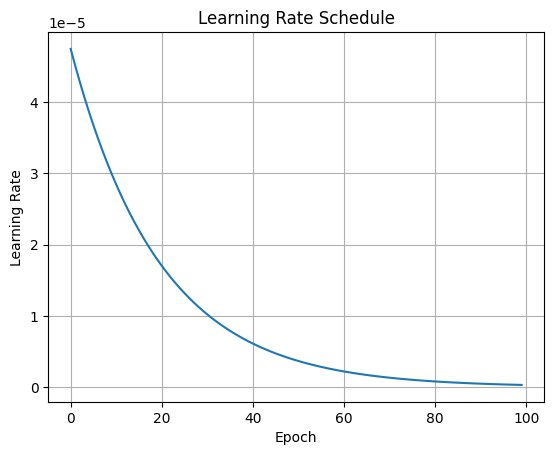

In [72]:
"""
Learning rate schedule visualizer
"""
lrs = []
num_epochs = 100  # Adjust number of epochs as needed
for epoch in range(num_epochs):
    optimizer.step()  # Dummy step, replace with your training step
    scheduler.step()
    lrs.append(optimizer.param_groups[0]['lr'])

plt.plot(range(num_epochs), lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

In [56]:
# Training loop
min_val_loss = float('inf') #check for least validation loss

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    with tqdm(total=len(train_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
      for inputs, targets in train_dataloader:
          inputs, targets = inputs.to(device), targets.to(device)

          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs.to(device), targets[0].to(device))

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          train_loss += loss.item() * inputs.size(0)
      scheduler.step() #scheduler step
      train_loss /= len(train_dataloader.dataset)

      with torch.no_grad():
        # Validation loop
        model.eval()
        val_loss = 0.0
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)

        val_loss /= len(test_dataloader.dataset)

        if val_loss < min_val_loss: #save weight only if validation loss is least
          torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          }, save_dir)
          min_val_loss = val_loss
          print("Model saved")

        # current_lr = optimizer.param_groups[0]['lr']
        if (epoch + 1) % 1 == 0:
          print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Min Val Loss: {min_val_loss:.4f}')

      pbar.update(1)


Epoch 1/100:   0%|          | 1/1236 [02:20<48:03:28, 140.09s/batch]


Model saved
Epoch [1/100], Train Loss: 184.3742, Val Loss: 177.2023, Min Val Loss: 177.2023, Learning Rate: 5e-05


Epoch 2/100:   0%|          | 1/1236 [02:20<48:13:41, 140.58s/batch]


Model saved
Epoch [2/100], Train Loss: 163.9384, Val Loss: 153.8868, Min Val Loss: 153.8868, Learning Rate: 5e-05


Epoch 3/100:   0%|          | 1/1236 [02:20<48:04:04, 140.12s/batch]


Model saved
Epoch [3/100], Train Loss: 141.1093, Val Loss: 128.5987, Min Val Loss: 128.5987, Learning Rate: 5e-05


Epoch 4/100:   0%|          | 1/1236 [02:20<48:05:09, 140.17s/batch]


Model saved
Epoch [4/100], Train Loss: 116.5067, Val Loss: 102.9000, Min Val Loss: 102.9000, Learning Rate: 5e-05


Epoch 5/100:   0%|          | 1/1236 [02:20<48:13:15, 140.56s/batch]


Model saved
Epoch [5/100], Train Loss: 89.6821, Val Loss: 74.6617, Min Val Loss: 74.6617, Learning Rate: 5e-05


Epoch 6/100:   0%|          | 1/1236 [02:20<48:12:03, 140.50s/batch]


Model saved
Epoch [6/100], Train Loss: 59.9663, Val Loss: 43.5075, Min Val Loss: 43.5075, Learning Rate: 5e-05


Epoch 7/100:   0%|          | 1/1236 [02:20<48:13:04, 140.55s/batch]


Model saved
Epoch [7/100], Train Loss: 27.3896, Val Loss: 9.4617, Min Val Loss: 9.4617, Learning Rate: 5e-05


Epoch 8/100:   0%|          | 1/1236 [02:20<48:07:17, 140.27s/batch]


Model saved
Epoch [8/100], Train Loss: 1.8767, Val Loss: 0.6626, Min Val Loss: 0.6626, Learning Rate: 5e-05


Epoch 9/100:   0%|          | 1/1236 [02:20<48:11:14, 140.47s/batch]


Epoch [9/100], Train Loss: 0.5672, Val Loss: 0.8654, Min Val Loss: 0.6626, Learning Rate: 5e-05


Epoch 10/100:   0%|          | 1/1236 [02:20<48:05:36, 140.19s/batch]


Epoch [10/100], Train Loss: 0.5809, Val Loss: 1.1092, Min Val Loss: 0.6626, Learning Rate: 5e-05


Epoch 11/100:   0%|          | 1/1236 [02:19<48:00:55, 139.96s/batch]


Epoch [11/100], Train Loss: 0.5694, Val Loss: 1.0223, Min Val Loss: 0.6626, Learning Rate: 5e-05


Epoch 12/100:   0%|          | 1/1236 [02:20<48:03:45, 140.10s/batch]


Epoch [12/100], Train Loss: 0.5624, Val Loss: 0.8289, Min Val Loss: 0.6626, Learning Rate: 5e-05


Epoch 13/100:   0%|          | 1/1236 [02:19<47:59:14, 139.88s/batch]


Epoch [13/100], Train Loss: 0.5632, Val Loss: 0.9259, Min Val Loss: 0.6626, Learning Rate: 5e-05


Epoch 14/100:   0%|          | 1/1236 [02:19<48:00:13, 139.93s/batch]


Epoch [14/100], Train Loss: 0.5662, Val Loss: 0.8691, Min Val Loss: 0.6626, Learning Rate: 5e-05


Epoch 15/100:   0%|          | 1/1236 [02:19<47:59:37, 139.90s/batch]


Epoch [15/100], Train Loss: 0.5841, Val Loss: 0.7983, Min Val Loss: 0.6626, Learning Rate: 5e-05


Epoch 16/100:   0%|          | 1/1236 [02:20<48:02:00, 140.02s/batch]


Epoch [16/100], Train Loss: 0.5622, Val Loss: 0.9579, Min Val Loss: 0.6626, Learning Rate: 5e-05


Epoch 17/100:   0%|          | 1/1236 [02:19<47:59:51, 139.91s/batch]


Epoch [17/100], Train Loss: 0.5822, Val Loss: 0.8931, Min Val Loss: 0.6626, Learning Rate: 5e-05


Epoch 18/100:   0%|          | 1/1236 [02:19<47:59:34, 139.90s/batch]


Epoch [18/100], Train Loss: 0.5836, Val Loss: 0.7714, Min Val Loss: 0.6626, Learning Rate: 5e-05


Epoch 19/100:   0%|          | 1/1236 [02:20<48:03:58, 140.11s/batch]


Model saved
Epoch [19/100], Train Loss: 0.5818, Val Loss: 0.4919, Min Val Loss: 0.4919, Learning Rate: 5e-05


Epoch 20/100:   0%|          | 1/1236 [02:20<48:06:02, 140.21s/batch]


Model saved
Epoch [20/100], Train Loss: 0.5858, Val Loss: 0.4586, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 21/100:   0%|          | 1/1236 [02:20<48:06:05, 140.22s/batch]


Epoch [21/100], Train Loss: 0.5735, Val Loss: 0.6478, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 22/100:   0%|          | 1/1236 [02:19<48:00:32, 139.95s/batch]


Epoch [22/100], Train Loss: 0.5829, Val Loss: 0.9436, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 23/100:   0%|          | 1/1236 [02:20<48:07:52, 140.30s/batch]


Epoch [23/100], Train Loss: 0.5878, Val Loss: 0.8818, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 24/100:   0%|          | 1/1236 [02:20<48:06:07, 140.22s/batch]


Epoch [24/100], Train Loss: 0.5876, Val Loss: 0.6969, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 25/100:   0%|          | 1/1236 [02:20<48:04:14, 140.13s/batch]


Epoch [25/100], Train Loss: 0.5696, Val Loss: 1.0714, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 26/100:   0%|          | 1/1236 [02:19<48:01:28, 139.99s/batch]


Epoch [26/100], Train Loss: 0.5660, Val Loss: 0.8074, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 27/100:   0%|          | 1/1236 [02:19<48:00:52, 139.96s/batch]


Epoch [27/100], Train Loss: 0.5711, Val Loss: 0.6156, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 28/100:   0%|          | 1/1236 [02:20<48:03:53, 140.11s/batch]


Epoch [28/100], Train Loss: 0.5719, Val Loss: 0.4784, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 29/100:   0%|          | 1/1236 [02:20<48:01:47, 140.01s/batch]


Epoch [29/100], Train Loss: 0.5848, Val Loss: 0.9013, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 30/100:   0%|          | 1/1236 [02:19<48:01:20, 139.98s/batch]


Epoch [30/100], Train Loss: 0.5581, Val Loss: 0.7902, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 31/100:   0%|          | 1/1236 [02:20<48:02:40, 140.05s/batch]


Epoch [31/100], Train Loss: 0.5721, Val Loss: 0.7274, Min Val Loss: 0.4586, Learning Rate: 5e-05


Epoch 32/100:   0%|          | 1/1236 [02:20<48:09:54, 140.40s/batch]


Model saved
Epoch [32/100], Train Loss: 0.5958, Val Loss: 0.4387, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 33/100:   0%|          | 1/1236 [02:20<48:03:37, 140.10s/batch]


Epoch [33/100], Train Loss: 0.5775, Val Loss: 0.6353, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 34/100:   0%|          | 1/1236 [02:20<48:03:55, 140.11s/batch]


Epoch [34/100], Train Loss: 0.5884, Val Loss: 0.9569, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 35/100:   0%|          | 1/1236 [02:20<48:03:16, 140.08s/batch]


Epoch [35/100], Train Loss: 0.6001, Val Loss: 0.7919, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 36/100:   0%|          | 1/1236 [02:19<48:00:51, 139.96s/batch]


Epoch [36/100], Train Loss: 0.5876, Val Loss: 0.7302, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 37/100:   0%|          | 1/1236 [02:19<47:57:51, 139.82s/batch]


Epoch [37/100], Train Loss: 0.5814, Val Loss: 0.8141, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 38/100:   0%|          | 1/1236 [02:19<47:58:25, 139.84s/batch]


Epoch [38/100], Train Loss: 0.5829, Val Loss: 0.9619, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 39/100:   0%|          | 1/1236 [02:19<47:59:47, 139.91s/batch]


Epoch [39/100], Train Loss: 0.5706, Val Loss: 0.6054, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 40/100:   0%|          | 1/1236 [02:19<48:01:15, 139.98s/batch]


Epoch [40/100], Train Loss: 0.5816, Val Loss: 1.0019, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 41/100:   0%|          | 1/1236 [02:19<48:00:59, 139.97s/batch]


Epoch [41/100], Train Loss: 0.5921, Val Loss: 0.7675, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 42/100:   0%|          | 1/1236 [02:20<48:04:08, 140.12s/batch]


Epoch [42/100], Train Loss: 0.5702, Val Loss: 0.8586, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 43/100:   0%|          | 1/1236 [02:20<48:01:42, 140.00s/batch]


Epoch [43/100], Train Loss: 0.5644, Val Loss: 0.9952, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 44/100:   0%|          | 1/1236 [02:19<47:58:56, 139.87s/batch]


Epoch [44/100], Train Loss: 0.5696, Val Loss: 0.6157, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 45/100:   0%|          | 1/1236 [02:19<48:00:25, 139.94s/batch]


Epoch [45/100], Train Loss: 0.5677, Val Loss: 0.7043, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 46/100:   0%|          | 1/1236 [02:19<47:59:38, 139.90s/batch]


Epoch [46/100], Train Loss: 0.6084, Val Loss: 0.5833, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 47/100:   0%|          | 1/1236 [02:20<48:04:32, 140.14s/batch]


Epoch [47/100], Train Loss: 0.5629, Val Loss: 0.9082, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 48/100:   0%|          | 1/1236 [02:19<48:00:19, 139.94s/batch]


Epoch [48/100], Train Loss: 0.5843, Val Loss: 0.9924, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 49/100:   0%|          | 1/1236 [02:19<47:55:13, 139.69s/batch]


Epoch [49/100], Train Loss: 0.5713, Val Loss: 0.8497, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 50/100:   0%|          | 1/1236 [02:20<48:02:30, 140.04s/batch]


Epoch [50/100], Train Loss: 0.5770, Val Loss: 0.7992, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 51/100:   0%|          | 1/1236 [02:20<48:02:45, 140.05s/batch]


Epoch [51/100], Train Loss: 0.5861, Val Loss: 0.7950, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 52/100:   0%|          | 1/1236 [02:20<48:03:09, 140.07s/batch]


Epoch [52/100], Train Loss: 0.5613, Val Loss: 0.7678, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 53/100:   0%|          | 1/1236 [02:20<48:03:54, 140.11s/batch]


Epoch [53/100], Train Loss: 0.5868, Val Loss: 0.8797, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 54/100:   0%|          | 1/1236 [02:20<48:03:26, 140.09s/batch]


Epoch [54/100], Train Loss: 0.5534, Val Loss: 0.7407, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 55/100:   0%|          | 1/1236 [02:20<48:04:43, 140.15s/batch]


Epoch [55/100], Train Loss: 0.5867, Val Loss: 0.8190, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 56/100:   0%|          | 1/1236 [02:20<48:02:06, 140.02s/batch]


Epoch [56/100], Train Loss: 0.5884, Val Loss: 0.7410, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 57/100:   0%|          | 1/1236 [02:19<48:01:21, 139.98s/batch]


Epoch [57/100], Train Loss: 0.5661, Val Loss: 0.8754, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 58/100:   0%|          | 1/1236 [02:20<48:02:29, 140.04s/batch]


Epoch [58/100], Train Loss: 0.5633, Val Loss: 0.8874, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 59/100:   0%|          | 1/1236 [02:20<48:02:03, 140.02s/batch]


Epoch [59/100], Train Loss: 0.5734, Val Loss: 0.8698, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 60/100:   0%|          | 1/1236 [02:20<48:01:43, 140.00s/batch]


Epoch [60/100], Train Loss: 0.5762, Val Loss: 1.0197, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 61/100:   0%|          | 1/1236 [02:20<48:02:21, 140.03s/batch]


Epoch [61/100], Train Loss: 0.5789, Val Loss: 0.9241, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 62/100:   0%|          | 1/1236 [02:20<48:01:57, 140.01s/batch]


Epoch [62/100], Train Loss: 0.5807, Val Loss: 0.6052, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 63/100:   0%|          | 1/1236 [02:20<48:03:39, 140.10s/batch]


Epoch [63/100], Train Loss: 0.5973, Val Loss: 0.6750, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 64/100:   0%|          | 1/1236 [02:20<48:04:37, 140.14s/batch]


Epoch [64/100], Train Loss: 0.5819, Val Loss: 0.6940, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 65/100:   0%|          | 1/1236 [02:20<48:06:25, 140.23s/batch]


Epoch [65/100], Train Loss: 0.5805, Val Loss: 0.4637, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 66/100:   0%|          | 1/1236 [02:20<48:05:58, 140.21s/batch]


Epoch [66/100], Train Loss: 0.5735, Val Loss: 0.9268, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 67/100:   0%|          | 1/1236 [02:20<48:05:03, 140.16s/batch]


Epoch [67/100], Train Loss: 0.5646, Val Loss: 0.8425, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 68/100:   0%|          | 1/1236 [02:20<48:06:05, 140.21s/batch]


Epoch [68/100], Train Loss: 0.5714, Val Loss: 0.8469, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 69/100:   0%|          | 1/1236 [02:20<48:03:15, 140.08s/batch]


Epoch [69/100], Train Loss: 0.5587, Val Loss: 0.9492, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 70/100:   0%|          | 1/1236 [02:19<48:00:04, 139.92s/batch]


Epoch [70/100], Train Loss: 0.5704, Val Loss: 0.9814, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 71/100:   0%|          | 1/1236 [02:20<48:02:38, 140.05s/batch]


Epoch [71/100], Train Loss: 0.5792, Val Loss: 0.7471, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 72/100:   0%|          | 1/1236 [02:20<48:04:13, 140.12s/batch]


Epoch [72/100], Train Loss: 0.5894, Val Loss: 0.8118, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 73/100:   0%|          | 1/1236 [02:19<48:00:57, 139.97s/batch]


Epoch [73/100], Train Loss: 0.5801, Val Loss: 0.8063, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 74/100:   0%|          | 1/1236 [02:19<47:58:37, 139.85s/batch]


Epoch [74/100], Train Loss: 0.5889, Val Loss: 0.8376, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 75/100:   0%|          | 1/1236 [02:19<47:59:38, 139.90s/batch]


Epoch [75/100], Train Loss: 0.5884, Val Loss: 0.4414, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 76/100:   0%|          | 1/1236 [02:19<47:59:53, 139.91s/batch]


Epoch [76/100], Train Loss: 0.5934, Val Loss: 0.6046, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 77/100:   0%|          | 1/1236 [02:20<48:03:09, 140.07s/batch]


Epoch [77/100], Train Loss: 0.5559, Val Loss: 0.9149, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 78/100:   0%|          | 1/1236 [02:19<47:59:50, 139.91s/batch]


Epoch [78/100], Train Loss: 0.5834, Val Loss: 0.5681, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 79/100:   0%|          | 1/1236 [02:20<48:01:45, 140.00s/batch]


Epoch [79/100], Train Loss: 0.5868, Val Loss: 0.7225, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 80/100:   0%|          | 1/1236 [02:19<48:00:01, 139.92s/batch]


Epoch [80/100], Train Loss: 0.5945, Val Loss: 0.9181, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 81/100:   0%|          | 1/1236 [02:20<48:03:06, 140.07s/batch]


Epoch [81/100], Train Loss: 0.5799, Val Loss: 0.8537, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 82/100:   0%|          | 1/1236 [02:19<48:00:00, 139.92s/batch]


Epoch [82/100], Train Loss: 0.5801, Val Loss: 0.7061, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 83/100:   0%|          | 1/1236 [02:19<47:58:36, 139.85s/batch]


Epoch [83/100], Train Loss: 0.5588, Val Loss: 1.0205, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 84/100:   0%|          | 1/1236 [02:19<47:58:24, 139.84s/batch]


Epoch [84/100], Train Loss: 0.5842, Val Loss: 0.8691, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 85/100:   0%|          | 1/1236 [02:19<48:00:15, 139.93s/batch]


Epoch [85/100], Train Loss: 0.5792, Val Loss: 0.7689, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 86/100:   0%|          | 1/1236 [02:19<48:01:23, 139.99s/batch]


Epoch [86/100], Train Loss: 0.5836, Val Loss: 0.9016, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 87/100:   0%|          | 1/1236 [02:20<48:04:42, 140.15s/batch]


Epoch [87/100], Train Loss: 0.5776, Val Loss: 0.9389, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 88/100:   0%|          | 1/1236 [02:20<48:02:24, 140.04s/batch]


Epoch [88/100], Train Loss: 0.5846, Val Loss: 0.9065, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 89/100:   0%|          | 1/1236 [02:20<48:01:42, 140.00s/batch]


Epoch [89/100], Train Loss: 0.5785, Val Loss: 0.8261, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 90/100:   0%|          | 1/1236 [02:19<47:59:03, 139.87s/batch]


Epoch [90/100], Train Loss: 0.5778, Val Loss: 0.9695, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 91/100:   0%|          | 1/1236 [02:19<48:00:16, 139.93s/batch]


Epoch [91/100], Train Loss: 0.5733, Val Loss: 0.7347, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 92/100:   0%|          | 1/1236 [02:20<48:02:39, 140.05s/batch]


Epoch [92/100], Train Loss: 0.5726, Val Loss: 0.6430, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 93/100:   0%|          | 1/1236 [02:20<48:05:48, 140.20s/batch]


Epoch [93/100], Train Loss: 0.5748, Val Loss: 0.8950, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 94/100:   0%|          | 1/1236 [02:19<47:59:10, 139.88s/batch]


Epoch [94/100], Train Loss: 0.5852, Val Loss: 0.7495, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 95/100:   0%|          | 1/1236 [02:19<47:57:45, 139.81s/batch]


Epoch [95/100], Train Loss: 0.5635, Val Loss: 0.7075, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 96/100:   0%|          | 1/1236 [02:20<48:02:30, 140.04s/batch]


Epoch [96/100], Train Loss: 0.5908, Val Loss: 0.5887, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 97/100:   0%|          | 1/1236 [02:20<48:05:08, 140.17s/batch]


Epoch [97/100], Train Loss: 0.5827, Val Loss: 0.6626, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 98/100:   0%|          | 1/1236 [02:19<48:01:38, 140.00s/batch]


Epoch [98/100], Train Loss: 0.5991, Val Loss: 0.7946, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 99/100:   0%|          | 1/1236 [02:19<47:55:55, 139.72s/batch]


Epoch [99/100], Train Loss: 0.5929, Val Loss: 0.9279, Min Val Loss: 0.4387, Learning Rate: 5e-05


Epoch 100/100:   0%|          | 1/1236 [02:19<47:56:42, 139.76s/batch]

Epoch [100/100], Train Loss: 0.5695, Val Loss: 0.9464, Min Val Loss: 0.4387, Learning Rate: 5e-05


In [59]:
checkpoint = torch.load(save_dir)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [60]:
#Selecting 1 batch of data randomly
input, label = next(iter(test_dataloader))
input= input.to(device)
label=label.to("cpu").numpy()

In [61]:
pred=model(input).to("cpu").detach().numpy() #getting model prediction

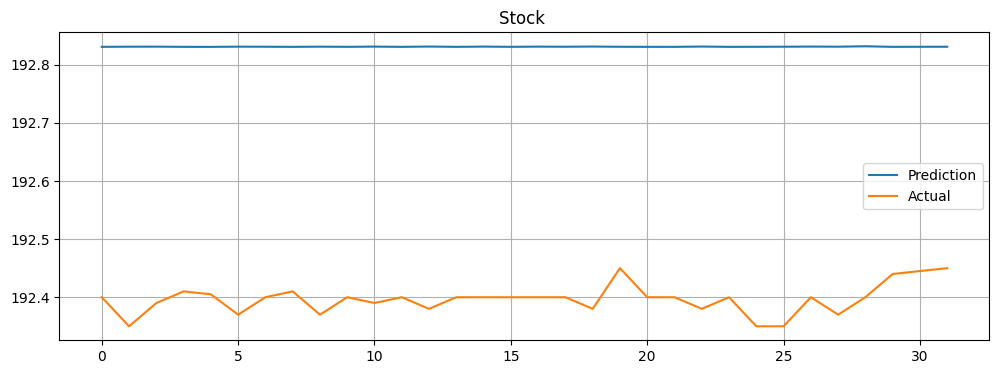

In [64]:
"""
Plot results
"""
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))

# Plot predictions and actual values with labels
ax1.plot(pred, label="Prediction")
ax1.plot(label, label="Actual")

# Set title and grid
plt.title("Stock ")
plt.grid(which="both")

# Show legend
plt.legend()

# Display the plot
plt.show()


In [69]:
"""
Calculate evaluation metrics value
"""
mse = np.mean((label - pred) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((label - pred) / label)) * 100

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

MSE: 0.1893
RMSE: 0.4351
MAPE: 0.2258
